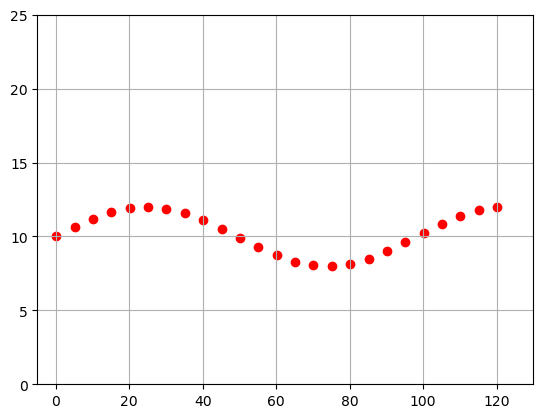

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pdb

# Sphere class
class Sphere:
    def __init__(self, position, velocity, stokes_no, vel_others, drag_acc):
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.acceleration = np.zeros(3, dtype=float)
        self.stokes_no = stokes_no
        self.vel_others = np.zeros(3, dtype=float)
        self.drag_acc = np.array(drag_acc, dtype=float)
        self.position_history = [self.position.copy()]
        self.velocity_history = [self.velocity.copy()]
        self.acceleration_history = [self.acceleration.copy()]
        self.drag_acc_history = [self.drag_acc.copy()]

    def update_vel_others(self, new_vel_others):
        self.vel_others = new_vel_others

    def update(self, new_position, new_velocity, new_acceleration, new_stokes_no, new_vel_others, new_drag_acc):
        self.position = new_position
        self.velocity = new_velocity
        self.acceleration = new_acceleration
        self.stokes_no = new_stokes_no
        self.vel_others = new_vel_others
        self.drag_acc = new_drag_acc
        self.position_history.append(self.position.copy())
        self.velocity_history.append(self.velocity.copy())
        self.acceleration_history.append(self.acceleration.copy())
        self.drag_acc_history.append(self.drag_acc.copy())


# Parameters

acceleration_threshold = 1000
velocity_threshold = 100

#Time scales
t_flow = 100   #flow time
omega = 1e-4    #Rotational frequency
t_response = 100   #Response time of the particle

#Fluid parameter
mu = 1/(np.pi*6*t_response) # viscosity
g = 6.0

#Units for Non-dimensionalisation
v_terminal = g * t_response

time_unit = t_flow
velocity_unit = v_terminal
length_unit =  velocity_unit* time_unit

#Particles
FR_PART = 1/20.0
N = 25  # Number of particles
A = 2*length_unit  # Amplitude of the sinusoid
d = 5*length_unit  # Interparticle distance

#Non-dimensional numbers
ST = t_response / t_flow  # Stokes number wrt flow
ST_ROT = t_response * omega  # Stokes number wrt rotation"

#Perturbation
k = 1  # Wave number

x_offset = 6000  # Base x position offset
y_offset = 600000  # Base y position offset


# Initial positions and velocities of spheres with sinusoidal perturbation
spheres = []
for i in range(N):
    x_position = x_offset + i * d
    #y_position =  y_offset + A * np.sin(k * (x_position - x_offset))
    y_position = y_offset  + A * np.sin(k * 8 * (x_position - 6000) / (N * d))
    #y_position = y_offset  + A * np.sin(k * 8 * (x_position - 6000) / (N * d))
    initial_position = np.array([x_position, y_position, 0])/length_unit #Non-dimensionalisation
    initial_velocity = np.array([0, 0.0*v_terminal, 0])/v_terminal #Non-dimensionalisation
    initial_drag_acc = -(1 / ST) * (initial_velocity) 

    spheres.append(Sphere(position=initial_position, velocity=initial_velocity, stokes_no=ST, vel_others=np.zeros(3), drag_acc=initial_drag_acc))


# Gravity force on particles
acc_g = np.array([[0, -g, 0] for _ in range(N)], dtype=float)

# Function to compute the G matrix
def compute_G_matrix(positions, mu):
    N = len(positions)
    G_matrix = np.zeros((3*N, 3*N))  # Initialize the G matrix
    for i in range(N):
        for j in range(N):
            if i != j:
                r_diff = positions[i] - positions[j]
                r_norm = np.linalg.norm(r_diff)
                I = np.eye(3)
                if r_norm == 0:
                    G = np.zeros((3, 3))  # Avoid division by zero at the singularity
                else:
                    G = (1 / (8 * np.pi * mu)) * (I / r_norm + np.outer(r_diff, r_diff) / r_norm ** 3)
                G_matrix[3*i:3*i+3, 3*j:3*j+3] = G

    return G_matrix

def check_G_matrix(G_matrix, threshold):
    large_values = G_matrix > threshold
    small_values = G_matrix < -threshold
    if np.any(large_values) or np.any(small_values):
        print("Warning: G_matrix contains values exceeding the threshold.")
        print("Max value in G_matrix:", np.max(G_matrix))
        print("Min value in G_matrix:", np.min(G_matrix))
        pdb.set_trace()
    else:
        print("G_matrix values are within the safe range.")

# Function to calculate growth rate
def calculate_growth_rate(initial_y_values, current_y_values, t):
    betas = (1 / t) * np.log(current_y_values / initial_y_values)
    return betas

# Identify the initial peaks (maxima) and valleys (minima) from the sinusoidal perturbation
initial_y_values = np.array([sphere.position[1] for sphere in spheres])
initial_max_indices = np.where(initial_y_values == np.max(initial_y_values))[0]
initial_min_indices = np.where(initial_y_values == np.min(initial_y_values))[0]

initial_max_y = initial_y_values[initial_max_indices]
initial_min_y = initial_y_values[initial_min_indices]

# Time array for storing growth rates
growth_rates_max = []
growth_rates_min = []
times = []



# Function to solve for vel_others
def solve_for_vel_others(spheres, G_matrix):
    N = len(spheres)
    velocities = np.array([sphere.velocity for sphere in spheres]).flatten()
    vel_others = np.zeros_like(velocities)

    # Construct the right-hand side of the equation
    rhs = np.zeros(3 * N)
    for i in range(N):
        for j in range(N):
            if i != j:
                G_ij = G_matrix[3*i:3*i+3, 3*j:3*j+3]
                rhs[3*i:3*i+3] += G_ij @ (velocities[3*j:3*j+3] - vel_others[3*j:3*j+3])/ST
                #print(rhs)

    # Solve for vel_others
    A = np.eye(3 * N) - G_matrix
    vel_others = np.linalg.solve(A, rhs)

    # Update spheres with new vel_others
    vel_others = vel_others.reshape((N, 3))
    for i, sphere in enumerate(spheres):
        sphere.update_vel_others(vel_others[i])

# Function to solve the ODE
def velocity_ode(t, v, vel_others, ST, ST_ROT, g, FR_PART):
    Zhat = np.array([0, 0, 1])
    yhat = np.array([0, 1, 0])
    dv_dt = (vel_others - v) / ST -2* np.cross(ST_ROT * Zhat, v) - (1 /ST) * yhat
    return dv_dt

# Helper function to calculate the average of the last five values in a list
def calculate_average_of_last_five(history_list):
    if len(history_list) >= 5:
        return np.mean(history_list[-5:], axis=0)
    else:
        return np.mean(history_list, axis=0)

# Function to check and scale down values if blow-up is detected
def check_and_scale_blow_up(sphere, velocity_threshold, acceleration_threshold):
    current_velocity = sphere.velocity
    current_acceleration = sphere.acceleration
    
    # Check if the velocity exceeds the threshold
    if np.linalg.norm(current_velocity) > velocity_threshold:
        avg_velocity = calculate_average_of_last_five(sphere.velocity_history)
        print(f"Velocity blow-up detected. Scaling down to average of last 5 time steps: {avg_velocity}")
        sphere.velocity = avg_velocity  # Scale down to the average velocity
    
    # Check if the acceleration exceeds the threshold
    if np.linalg.norm(current_acceleration) > acceleration_threshold:
        avg_acceleration = calculate_average_of_last_five(sphere.acceleration_history)
        print(f"Acceleration blow-up detected. Scaling down to average of last 5 time steps: {avg_acceleration}")
        sphere.acceleration = avg_acceleration  # Scale down to the average acceleration
        
#check the initial position
fig, ax = plt.subplots()
plt.grid(True)
ax.set_xlim(-5, 130)
ax.set_ylim(0, 25)
ax.grid(True)
ax.scatter([sphere.position[0] for sphere in spheres], [sphere.position[1] for sphere in spheres], color='r')
plt.show()



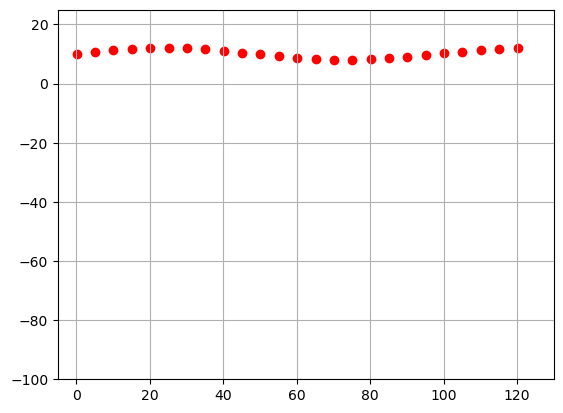

In [2]:
fig, ax = plt.subplots()
plt.grid(True)
ax.set_xlim(-5, 130)
ax.set_ylim(-100, 25)
ax.grid(True)
ax.scatter([sphere.position[0] for sphere in spheres], [sphere.position[1] for sphere in spheres], color='r')
plt.show()

In [3]:
print("Stokes", ST)
print("Stokes_rot", ST_ROT)
print("vel",spheres[0].velocity)
print("u infini",spheres[0].vel_others)
print("drag",(spheres[0].vel_others - spheres[0].velocity)/ST)
print("mu",mu)
print("vterminal", g*t_response)
print("g term" ,1/ST)

# Function to integrate velocities to find positions and update spheres
def integrate_and_update_spheres(spheres, dt):
    for sphere in spheres:
        # Solve the ODE to get the new velocity
        sol = solve_ivp(velocity_ode, [0, dt], sphere.velocity, method='LSODA', args=(sphere.vel_others, ST, ST_ROT, g, FR_PART), t_eval=[dt])
        new_velocity = sol.y[:, -1]

        # Update position
        new_position = sphere.position + new_velocity * dt

        # Update acceleration
        new_acceleration = (new_velocity - sphere.velocity) / dt

        # Update sphere
        sphere.update(new_position, new_velocity, new_acceleration, sphere.stokes_no, sphere.vel_others, sphere.drag_acc)
        
         # Check for blow-ups and scale down if necessary
        check_and_scale_blow_up(sphere, velocity_threshold, acceleration_threshold)


Stokes 1.0
Stokes_rot 0.01
vel [0. 0. 0.]
u infini [0. 0. 0.]
drag [0. 0. 0.]
mu 0.0005305164769729845
vterminal 600.0
g term 1.0


In [4]:
print(spheres[0].position)
spheres[1].position

[ 0.1 10.   0. ]


array([ 5.1       , 10.62913312,  0.        ])

Time step 1/1000
Particle 1 position: [ 0.1 10.   0. ]
Particle 1 velocity: [0. 0. 0.]
Particle 2 position: [ 5.1        10.62913312  0.        ]
Particle 2 velocity: [0. 0. 0.]
Particle 3 position: [10.1        11.19439088  0.        ]
Particle 3 velocity: [0. 0. 0.]
Particle 4 position: [15.1        11.63838314  0.        ]
Particle 4 velocity: [0. 0. 0.]
Particle 5 position: [20.1        11.91603172  0.        ]
Particle 5 velocity: [0. 0. 0.]
Particle 6 position: [25.1        11.99914721  0.        ]
Particle 6 velocity: [0. 0. 0.]
Particle 7 position: [30.1        11.87929095  0.        ]
Particle 7 velocity: [0. 0. 0.]
Particle 8 position: [35.1        11.56863185  0.        ]
Particle 8 velocity: [0. 0. 0.]
Particle 9 position: [40.1        11.09871087  0.        ]
Particle 9 velocity: [0. 0. 0.]
Particle 10 position: [45.1       10.5172387  0.       ]
Particle 10 velocity: [0. 0. 0.]
Particle 11 position: [50.1         9.88325171  0.        ]
Particle 11 velocity: [0. 0. 0.]
Pa

ZeroDivisionError: float division by zero

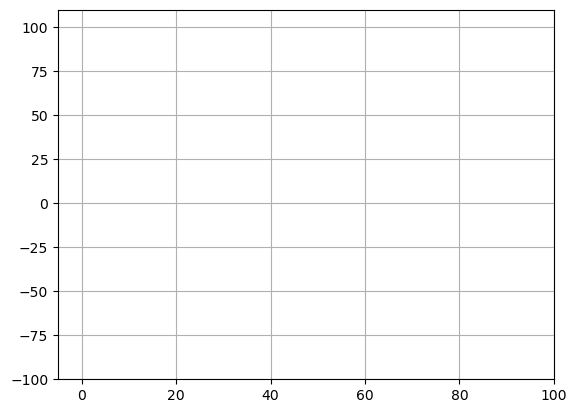

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots()
plt.grid(True)
ax.set_xlim(-5, 100)
ax.set_ylim(-100, 110)

dt = 0.1
total_time = 100
snapshots = 100  # Number of snapshots you want
time_steps = int(total_time / dt)
snapshot_interval = time_steps // snapshots

# Simulation loop
for step in range(time_steps):
    print(f"Time step {step+1}/{time_steps}")
    for i, sphere in enumerate(spheres):
        print(f"Particle {i+1} position: {sphere.position}")
        print(f"Particle {i+1} velocity: {sphere.velocity}")

    # Step 1: Solve linear system of equations to get vel_others of each sphere
    positions = np.array([sphere.position for sphere in spheres])
    G_matrix = compute_G_matrix(positions, mu)
    check_G_matrix(G_matrix, threshold=100)  # Adjust threshold as needed
    solve_for_vel_others(spheres, G_matrix)

    # Step 2 and 3: Solve the ODE and integrate velocities to find positions
    integrate_and_update_spheres(spheres, dt)
    
    if step == 0:
        continue

    # Make plots at specified intervals
    if step % snapshot_interval == 0:
        t = step * dt
        current_y_values = np.array([sphere.position[1] for sphere in spheres])
        
        current_max_y = current_y_values[initial_max_indices]
        current_min_y = current_y_values[initial_min_indices]
        
        beta_max = calculate_growth_rate(initial_max_y, current_max_y, t)
        beta_min = calculate_growth_rate(initial_min_y, current_min_y, t)
        
        growth_rates_max.append(beta_max)
        growth_rates_min.append(beta_min)
        times.append(t)
        
        print(f"Growth rate (beta_max) at time {t}: {beta_max}")
        print(f"Growth rate (beta_min) at time {t}: {beta_min}")
        ax.clear()
        ax.set_xlim(-5, 100)
        ax.set_ylim(-100, 110)
        ax.grid(True)
        ax.scatter([sphere.position[0] for sphere in spheres], [sphere.position[1] for sphere in spheres], color='r')
        plt.savefig(f'plots/plot_{step:04d}.png')  # Save the plot

# Print final positions and velocities
for i, sphere in enumerate(spheres):
    print(f"Particle {i+1} final position: {sphere.position}")
    print(f"Particle {i+1} final velocity: {sphere.velocity}")
    
# Plotting growth rate over time
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(times, growth_rates_max, label="Growth rate (beta_max)")
plt.plot(times, growth_rates_min, label="Growth rate (beta_min)")
plt.xlabel('Time')
plt.ylabel('Growth rate (beta)')
plt.title('Growth Rate of Perturbations Over Time')
plt.legend()
plt.show()


In [ ]:
(np.array(spheres[0].velocity_history)[:,1]).shape

def extract_y_velocity(sphere):
    return np.array(sphere.velocity_history)[:, 1]

blah = extract_y_velocity(spheres[0])

blah

array([ 0.        , -0.09516164, -0.1719043 , ..., -0.4916314 ,
       -0.49163183, -0.49163225])

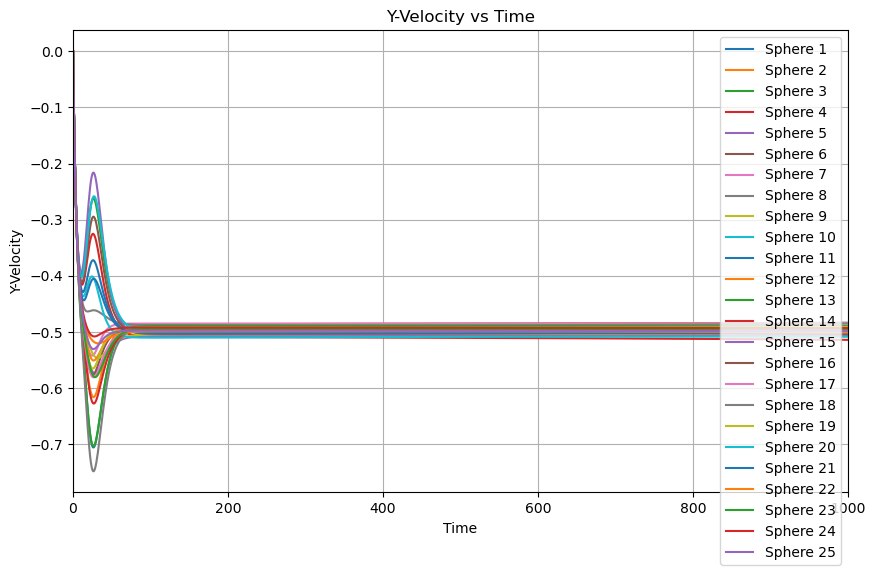

In [ ]:
import matplotlib.pyplot as plt

def plot_quantity_vs_time(spheres, quantity_function, quantity_label):
    """
    Plots a given quantity versus time for all spheres.

    Parameters:
    - spheres: List of Sphere objects.
    - quantity_function: A function that extracts the desired quantity from a sphere object.
    - quantity_label: A string representing the label of the quantity to be plotted.
    """
    # Time array based on the history length (assuming uniform time steps)
    time_steps = len(spheres[0].position_history)
    time_array = np.linspace(0, time_steps - 1, time_steps)

    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.title(f'{quantity_label} vs Time')

    for i, sphere in enumerate(spheres):
        # Extract the desired quantity over time
        quantity_values = quantity_function(sphere)
        plt.plot(time_array, quantity_values, label=f'Sphere {i + 1}')

    plt.xlabel('Time')
    plt.xlim(0,1000)
    #plt.ylim(-5.0,5.0)
    plt.ylabel(quantity_label)
    plt.legend()
    plt.show()

# Define the function to extract the desired quantity (e.g., y-velocity)
def extract_y_velocity(sphere):
    return np.array(sphere.velocity_history)[:, 1]  # Y-component of velocity

# Example usage:
plot_quantity_vs_time(spheres, extract_y_velocity, 'Y-Velocity')


In [ ]:
def extract_x_velocity(sphere):
    return np.array(sphere.velocity_history)[:, 0]  # Y-component of velocity

# Example usage:
plot_quantity_vs_time(spheres, extract_x_velocity, 'Y-Velocity')

NameError: name 'plot_quantity_vs_time' is not defined